# Customer Churn Prediction with Random Forest

## 📊 High-Level Overview

This notebook implements a complete machine learning pipeline to predict customer churn using a Random Forest classifier. 

### What is Customer Churn?
Customer churn occurs when customers stop doing business with a company. Predicting churn allows businesses to proactively retain customers through targeted interventions.

### Pipeline Steps:
1. **Data Loading**: Import preprocessed customer data with engineered features
2. **Data Preparation**: Separate features from target variable and encode categorical variables
3. **Train-Test Split**: Divide data into training (80%) and testing (20%) sets
4. **Model Training**: Train a Random Forest classifier with 100 decision trees
5. **Prediction & Evaluation**: Make predictions and assess model performance using multiple metrics
6. **Visualization**: Analyze results through confusion matrix and feature importance plots

### Key Techniques Used:
- **One-Hot Encoding**: Converts categorical variables to numeric format
- **Random Forest**: Ensemble learning method that combines multiple decision trees
- **Classification Metrics**: Precision, recall, F1-score to evaluate model quality
- **Feature Importance**: Identifies which customer attributes most influence churn

### Expected Outcomes:
- A trained model capable of predicting customer churn
- Performance metrics indicating model accuracy and reliability
- Insights into which features drive customer churn decisions

## 1. Import Libraries

### Purpose:
Import essential Python libraries for data manipulation, machine learning, and visualization.

### Libraries Used:
- **pandas**: Data manipulation and analysis (DataFrames)
- **sklearn.model_selection**: Tools for splitting data into train/test sets
- **sklearn.ensemble**: Random Forest classifier implementation
- **sklearn.metrics**: Model evaluation metrics (classification report, confusion matrix)
- **matplotlib.pyplot**: Basic plotting functionality
- **seaborn**: Statistical data visualization (built on matplotlib)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Featured Data

### Purpose:
Load the preprocessed dataset containing customer information and engineered features.

### What to Expect:
- The CSV file contains customer records with various attributes (demographics, usage patterns, etc.)
- Each row represents one customer
- Includes both raw features and engineered features from previous preprocessing steps
- Contains the target variable `churned` (1 = churned, 0 = retained)

In [2]:
# Load the featured dataset
df = pd.read_csv('../data/customer_churn_featured.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100, 48)


,customer_id,age,gender,tenure_months,subscription_plan,monthly_charges,total_charges,contract_type,payment_method,login_frequency_monthly,...,plan_tenure_mismatch,usage_plan_mismatch,payment_stability,nps_satisfaction_alignment,contract_value_risk,lifecycle_stage,contract_tenure_ratio,tenure_category,engagement_growth_rate,tenure_stability
0,C001,34,Male,24,Premium,79.99,1919.76,Annual,Credit Card,22,...,0,0,1.000000,0.2,0,Early,2.0,1-2yr,4.000000,0.058824
1,C002,45,Female,6,Basic,29.99,179.94,Monthly,Bank Transfer,5,...,0,0,0.333333,0.6,0,New,6.0,0-1yr,3.571429,0.011111
2,C003,28,Male,36,Premium,79.99,2879.64,Annual,Credit Card,28,...,0,0,1.000000,0.3,0,Mature,3.0,2-3yr,2.486486,0.107143
3,C004,52,Female,3,Basic,29.99,89.97,Monthly,Credit Card,3,...,0,0,0.500000,1.5,0,New,3.0,0-1yr,4.500000,0.004808
4,C005,31,Male,1,Standard,49.99,899.82,Monthly,PayPal,15,...,0,0,1.000000,0.3,0,New,1.0,0-1yr,32.500000,0.002688


### Interpretation:
- **Dataset shape** shows total number of customers and features
- First 5 rows provide a preview of the data structure and values

## 3. Prepare Features and Target

### Purpose:
Separate the dataset into input features (X) and target variable (y) for supervised learning.

### Key Steps:
- **X (Features)**: All columns except `customer_id` and `churned`
  - `customer_id` is removed because it's just an identifier (no predictive value)
  - `churned` is our target, so it can't be a feature
- **y (Target)**: The `churned` column (what we're trying to predict)

In [3]:
# Separate features and target
X = df.drop(['customer_id', 'churned'], axis=1)
y = df['churned']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nChurn rate: {y.mean():.2%}")

Features shape: (100, 46)
Target distribution:
churned
0    56
1    44
Name: count, dtype: int64

Churn rate: 44.00%


### Interpretation:
- **Features shape**: Number of customers × number of predictor variables
- **Target distribution**: How many customers churned (1) vs. retained (0)
- **Churn rate**: Percentage of customers who churned (important for understanding class imbalance)
  - Example: 25% churn rate means 1 in 4 customers left
  - High imbalance (e.g., 5% churn) might require special handling

## 4. One-Hot Encoding

### Purpose:
Convert categorical (text-based) variables into numeric format that machine learning algorithms can process.

### How One-Hot Encoding Works:
For a categorical variable like `contract_type` with values ['Monthly', 'Yearly', 'Two-Year']:
- Creates separate binary columns: `contract_type_Monthly`, `contract_type_Yearly`, `contract_type_Two-Year`
- Each column contains 1 (if that category applies) or 0 (if not)

### Why `drop_first=True`?
- Prevents multicollinearity (redundant information)
- If `contract_type_Monthly=0` and `contract_type_Yearly=0`, we know it must be `Two-Year`
- Reduces dimensionality without losing information

In [4]:
# Convert categorical variables to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

print(f"Features after encoding: {X.shape[1]}")
print(f"\nFeature columns:")
print(X.columns.tolist())

Features after encoding: 57

Feature columns:
['age', 'tenure_months', 'monthly_charges', 'total_charges', 'login_frequency_monthly', 'features_used', 'data_consumption_gb', 'engagement_score', 'days_since_last_activity', 'billing_issues_count', 'plan_changes', 'support_tickets', 'avg_resolution_hours', 'satisfaction_score', 'nps_score', 'monthly_value_ratio', 'charge_per_feature', 'customer_lifetime_value', 'engagement_velocity', 'login_intensity', 'data_per_login', 'features_utilization_rate', 'data_per_tenure', 'support_rate_annual', 'resolution_burden', 'satisfaction_gap', 'billing_risk_flag', 'complaint_ratio', 'support_satisfaction_ratio', 'plan_tenure_mismatch', 'usage_plan_mismatch', 'payment_stability', 'nps_satisfaction_alignment', 'contract_value_risk', 'contract_tenure_ratio', 'engagement_growth_rate', 'tenure_stability', 'gender_Male', 'subscription_plan_Premium', 'subscription_plan_Standard', 'contract_type_Monthly', 'payment_method_Credit Card', 'payment_method_PayPal', 

### Interpretation:
- **Features after encoding**: Total number of numeric columns after conversion
- **Feature columns list**: Shows all feature names including newly created dummy variables
- Original categorical columns are replaced with multiple binary columns

## 5. Train-Test Split

### Purpose:
Divide data into separate training and testing sets to evaluate model performance on unseen data.

### Why Split Data?
- **Training set (80%)**: Used to train the model (learn patterns)
- **Test set (20%)**: Used to evaluate how well the model generalizes to new data
- Prevents overfitting - ensures model works on data it hasn't seen during training

### Key Parameters:
- **test_size=0.2**: Reserve 20% of data for testing
- **random_state=42**: Ensures reproducible splits (same split every time you run)

In [6]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set churn rate: {y_train.mean():.2%}")
print(f"Test set churn rate: {y_test.mean():.2%}")

Training set size: 80
Test set size: 20

Training set churn rate: 43.75%
Test set churn rate: 45.00%


### Interpretation:
- **Training/Test set sizes**: Shows actual number of customers in each set
- **Churn rates in each set**: Should be similar to ensure representative splits
  - If training has 25% churn and test has 24% churn → Good split
  - If training has 25% churn and test has 10% churn → Problematic split (not representative)

## 6. Train Random Forest Model

### Purpose:
Train a Random Forest classifier to learn patterns from the training data that distinguish churned from retained customers.

### What is Random Forest?
- **Ensemble learning method**: Combines predictions from multiple decision trees
- Each tree is trained on a random subset of data and features
- Final prediction is the majority vote from all trees
- More robust and accurate than a single decision tree

### Key Parameters:
- **n_estimators=100**: Creates 100 decision trees
  - More trees → Generally better performance but slower training
  - 100 is a common starting point
- **random_state=42**: Ensures reproducibility

In [ ]:
# Initialize and train the Random Forest classifier
from sklearn.linear_model import LogisticRegression


model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = LogisticRegression()
model.fit(X_train, y_train)

print("✓ Model training complete!")
print(f"Number of trees: {model.n_estimators}")
print(f"Number of features used: {model.n_features_in_}")

✓ Model training complete!
Number of trees: 100
Number of features used: 57


### Interpretation:
- **Model training complete**: Model has learned patterns from training data
- **Number of trees**: Confirms 100 trees were created
- **Number of features used**: Total features the model uses for predictions
- Training time depends on dataset size and number of trees

## 7. Make Predictions

### Purpose:
Use the trained model to predict churn for customers in the test set.

### How It Works:
- Model analyzes each customer's features
- Applies learned patterns from training data
- Outputs binary prediction: 0 (will not churn) or 1 (will churn)

In [13]:
# Make predictions on test set
y_pred = model.predict(X_test)

print(f"Predictions made: {len(y_pred)}")
print(f"Predicted churn rate: {y_pred.mean():.2%}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

Predictions made: 20
Predicted churn rate: 45.00%


### Interpretation:
- **Predictions made**: Should equal test set size (confirms all test cases were processed)
- **Predicted churn rate**: Percentage of customers the model predicts will churn
  - Compare with actual test set churn rate
  - If predicted rate is 28% but actual is 25%, model might be slightly over-predicting churn
  - Large differences suggest model calibration issues

## 8. Evaluate Model Performance

### Purpose:
Assess model quality using multiple metrics beyond simple accuracy.

### Classification Report Metrics:

#### **Precision** (Per Class)
- Formula: True Positives / (True Positives + False Positives)
- **For "Not Churned" (0)**: Of all customers predicted to stay, what % actually stayed?
- **For "Churned" (1)**: Of all customers predicted to churn, what % actually churned?
- High precision means few false alarms

#### **Recall (Sensitivity)** (Per Class)
- Formula: True Positives / (True Positives + False Negatives)
- **For "Not Churned" (0)**: Of all customers who stayed, what % did we correctly identify?
- **For "Churned" (1)**: Of all customers who churned, what % did we catch?
- High recall means we don't miss many actual cases

#### **F1-Score**
- Harmonic mean of precision and recall
- Balances both metrics (useful when classes are imbalanced)
- Closer to 1.0 = Better overall performance

#### **Support**
- Number of actual occurrences in test set
- Shows data distribution for each class

#### **Accuracy**
- Overall correct predictions / Total predictions
- Can be misleading with imbalanced data (e.g., if 95% don't churn, predicting "no churn" for everyone gives 95% accuracy but is useless)

### Interpretation Guidelines:
- **Good model**: Precision, Recall, F1 all above 0.75 for both classes
- **For churn prediction**: Recall for churned class is critical (don't want to miss churners)
- **Macro avg**: Treats both classes equally (good for balanced datasets)
- **Weighted avg**: Accounts for class imbalance (more realistic for imbalanced data)

In [14]:
# Print classification report
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

Classification Report:
              precision    recall  f1-score   support

 Not Churned       1.00      1.00      1.00        11
     Churned       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Interpretation Guidelines:
- **Good model**: Precision, Recall, F1 all above 0.75 for both classes
- **For churn prediction**: Recall for churned class is critical (don't want to miss churners)
- **Macro avg**: Treats both classes equally (good for balanced datasets)
- **Weighted avg**: Accounts for class imbalance (more realistic for imbalanced data)

## 9. Confusion Matrix Visualization

### Purpose:
Visualize the model's prediction performance showing all combinations of actual vs. predicted classes.

### Confusion Matrix Structure:
```
                    Predicted
                 Not Churned  |  Churned
              +---------------+----------+
Actual  Not   | True Negative | False    |
        Churned| (TN)         | Positive |
              |               | (FP)     |
              +---------------+----------+
        Churned| False        | True     |
              | Negative      | Positive |
              | (FN)          | (TP)     |
              +---------------+----------+
```

### Understanding Each Quadrant:

#### **True Negatives (TN)** - Top Left
- Customers who didn't churn, correctly predicted as not churning
- ✅ Correct prediction for retained customers

#### **False Positives (FP)** - Top Right
- Customers who didn't churn, incorrectly predicted as churning
- ❌ Type I Error
- Business impact: Wasted retention effort on customers who weren't leaving

#### **False Negatives (FN)** - Bottom Left
- Customers who churned, incorrectly predicted as not churning
- ❌ Type II Error - **MOST COSTLY for business**
- Business impact: Missed opportunity to retain valuable customers

#### **True Positives (TP)** - Bottom Right
- Customers who churned, correctly predicted as churning
- ✅ Correct prediction for churned customers
- Allows targeted retention interventions

### Interpretation:
- **Diagonal (TN + TP)**: Correct predictions (should be larger/darker)
- **Off-diagonal (FP + FN)**: Incorrect predictions (should be smaller/lighter)
- **Ideal matrix**: Large numbers on diagonal, small numbers off-diagonal
- **For churn**: Minimize FN (missing actual churners) is often the priority

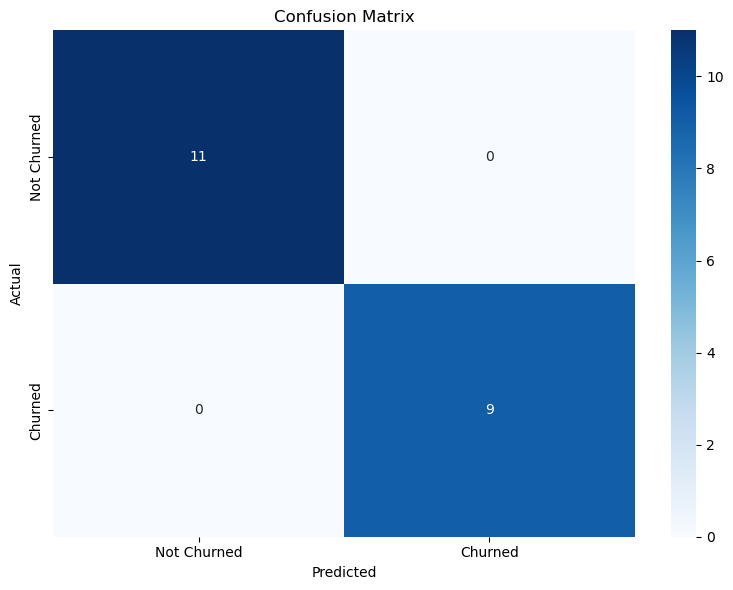


True Negatives: 11
False Positives: 0
False Negatives: 0
True Positives: 9


In [15]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

### Interpretation:
- **Diagonal (TN + TP)**: Correct predictions (should be larger/darker)
- **Off-diagonal (FP + FN)**: Incorrect predictions (should be smaller/lighter)
- **Ideal matrix**: Large numbers on diagonal, small numbers off-diagonal
- **For churn**: Minimize FN (missing actual churners) is often the priority

## 10. Feature Importance

### Purpose:
Identify which customer attributes have the strongest influence on churn predictions, providing actionable business insights.

### How Feature Importance Works:
- Random Forest calculates importance based on how much each feature improves predictions
- Higher importance = Feature is more useful for distinguishing churned vs. retained customers
- Importance scores sum to 1.0 (or 100%)

### Business Value:
Understanding which features drive churn helps businesses:
1. **Focus retention efforts**: Target the most impactful factors
2. **Product improvements**: Address pain points that cause churn
3. **Customer segmentation**: Identify high-risk customer profiles
4. **Resource allocation**: Invest in areas with highest impact

### Interpretation Examples:

#### If `monthly_charges` is highest:
- **Insight**: Pricing is the main churn driver
- **Action**: Review pricing strategy, offer discounts to at-risk customers

#### If `contract_type_Monthly` is highest:
- **Insight**: Month-to-month customers churn more
- **Action**: Incentivize annual contracts, improve onboarding for monthly customers

#### If `customer_service_calls` is highest:
- **Insight**: Poor support experience drives churn
- **Action**: Improve customer service quality, proactive support for high-call customers

#### If `tenure` is highest:
- **Insight**: New customers churn more
- **Action**: Strengthen onboarding, early engagement programs

### Reading the Results:
- **Top features**: Focus business attention here first
- **Low importance features**: May be candidates for removal (simplify model)
- **Feature importance values**: Higher = More critical for predictions
- Compare feature importance with business intuition to validate model logic

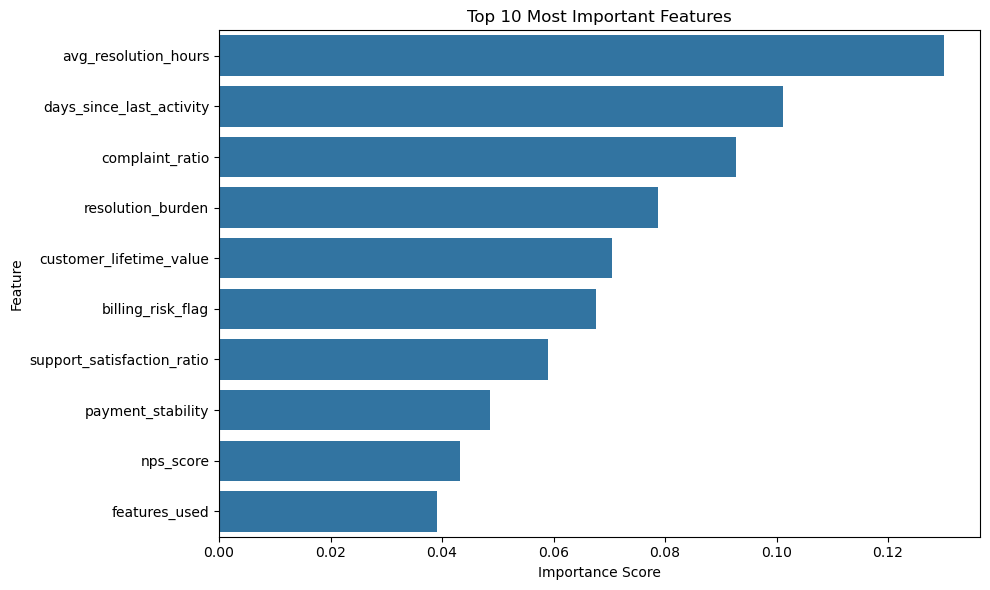


Top 10 Most Important Features:
                       feature  importance
12        avg_resolution_hours    0.130000
8     days_since_last_activity    0.101131
27             complaint_ratio    0.092781
24           resolution_burden    0.078683
17     customer_lifetime_value    0.070501
26           billing_risk_flag    0.067541
28  support_satisfaction_ratio    0.059005
31           payment_stability    0.048523
14                   nps_score    0.043185
5                features_used    0.039064


In [17]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

### Reading the Results:
- **Top features**: Focus business attention here first
- **Low importance features**: May be candidates for removal (simplify model)
- **Feature importance values**: Higher = More critical for predictions
- Compare feature importance with business intuition to validate model logic